# 🚀 Model-Agnostic Meta-Learning (MAML) on Omniglot

**Welcome to this hands-on tutorial!** 👋

This notebook provides a complete, modular implementation of MAML for few-shot learning on the Omniglot dataset. I assume you're already familiar with the MAML algorithm basics. If not, I recommend:
- 📖 Reading **"Meta-Learning: Theory, Algorithms and Applications"**
- 🎥 Watching **Stanford's CS330 lectures** on MAML by Chelsea Finn

This tutorial walks you through the **practical implementation** step-by-step, demonstrating how to use the modular functions provided in this repository.

## 🧠 What is Meta-Learning?

**In simple terms:** If Machine Learning teaches a model *how to do a task*, Meta-Learning teaches the model *how to learn* to do the task. 🎓

Think of it this way:
- **Machine Learning** 📖: "Here are 1000 cat images. Learn to recognize cats."
- **Meta-Learning** 🎯: "Learn how to quickly recognize new things (cats, dogs, cars) from just a few examples."

Meta-learning is essentially *learning to learn* - the model learns a learning strategy that generalizes across different tasks! 🔄

## 🎯 What You'll Learn

This notebook demonstrates how to use the **modular components** from this repository:
- 📂 `load_omniglot.py` - Dataset loading and task generation
- 🎨 `visualize_omniglot.py` - Data visualization utilities
- 🧠 `MAML.py` - Core MAML algorithm implementation
- 📊 `evaluate_maml.py` - Evaluation and visualization tools

### ✨ Key Features:
- **5-way 1-shot learning**: Classify 5 characters with only 1 example per class 🎯
- **Fast adaptation**: Fine-tune on new tasks in just a few gradient steps ⚡
- **Modular design**: Clean, reusable code that works with any dataset 🔧

### 📊 Dataset:
The Omniglot dataset contains 1,623 different handwritten characters from 50 different alphabets, with 20 examples per character. Often called the "MNIST of few-shot learning"!

### 📖 References:
- [MAML Paper](https://arxiv.org/abs/1703.03400) - Finn et al., 2017
- [Omniglot Dataset](https://github.com/brendenlake/omniglot)

---

Let's dive in! 🏊‍♂️

## 1️⃣ Import Dependencies

We'll import the necessary libraries plus the **modular components** from this repository:

**From this repository:**
- `load_omniglot` - Dataset loading (`OmniglotDataset`, `OmniglotTaskDataset`)
- `visualize_omniglot` - Visualization utilities (`visualize_task_sample`, `visualize_character_variations`)
- `MAML` - Core algorithm (`ModelAgnosticMetaLearning`, `train_maml`)
- `evaluate_maml` - Evaluation and plotting (`evaluate_maml`, `plot_evaluation_results`, `plot_training_progress`)

**External libraries:** PyTorch, NumPy, Matplotlib, PIL, tqdm 📦

In [1]:
import torch
from torch.utils.data import DataLoader

import sys
sys.path.append('..')

from utils.load_omniglot import OmniglotDataset, OmniglotTaskDataset, PrefetchedOmniglotDataset
from utils.visualize_omniglot import visualize_task_sample, visualize_character_variations
from evaluation.eval_visualization import plot_evaluation_results, plot_training_progress
from evaluation.evaluate_maml import evaluate_maml

from algorithms.maml import ModelAgnosticMetaLearning, train_maml

# Set optimal GPU settings
torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
torch.backends.cuda.matmul.allow_tf32 = True  # Enable TF32 on Ampere GPUs
torch.backends.cudnn.allow_tf32 = True

ModuleNotFoundError: No module named 'algorithms.maml'

## 2️⃣ Dataset Classes 🗂️

We use the dataset loaders from `load_omniglot.py`, which provides two key classes:

### `OmniglotDataset`
Loads all character classes from the Omniglot dataset. Each character class contains approximately 20 handwritten examples. 📝

**Usage**: `OmniglotDataset(data_path)` → Returns character images and class indices

### `OmniglotTaskDataset`
Generates N-way K-shot learning tasks by randomly sampling character classes and splitting their examples into support and query sets. 🎲

**Usage**: `OmniglotTaskDataset(dataset, n_way, k_shot, k_query, num_tasks)`

**Task Structure:**
- **Support Set** 📚: K examples per class (for adaptation)
- **Query Set** 🧪: Additional examples per class (for evaluation)

These classes are **modular and adaptable** - you can easily create similar classes for your own dataset by following the same pattern!

In [ ]:
# Create a sample dataset for visualization
# Note: Update the path according to your Kaggle input
sample_data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_background"

print("🔄 Loading a sample of the Omniglot dataset...")
sample_dataset = OmniglotDataset(sample_data_path)

print(f"\n✅ Dataset loaded successfully!")
print(f"📊 Total character classes: {len(sample_dataset)}")

# Create a sample task dataset
print("\n🎲 Creating sample tasks...")
sample_task_dataset = OmniglotTaskDataset(
    sample_dataset, 
    n_way=5,      # 5 different characters per task
    k_shot=1,     # 1 example per character for training (support)
    k_query=5,    # 5 examples per character for testing (query)
    num_tasks=10  # Just 10 tasks for demonstration
)

print("✅ Task dataset created!")
print(f"📦 Number of tasks: {len(sample_task_dataset)}")

🔄 Loading a sample of the Omniglot dataset...
Loading character paths...


Processing alphabets: 100%|██████████| 30/30 [00:02<00:00, 10.35it/s]

Found 964 character classes

✅ Dataset loaded successfully!
📊 Total character classes: 964

🎲 Creating sample tasks...
✅ Task dataset created!
📦 Number of tasks: 10


## 2.1 Visualize Dataset Samples 👀

Let's use the visualization utilities from `utils/visualize_omniglot.py` to see what the data looks like!

**Available functions:**
- `visualize_task_sample(task_dataset, task_idx)` - Display a complete task with support and query sets
- `visualize_character_variations(dataset, num_chars, max_examples)` - Show handwriting variations within classes

These visualizations help you understand the few-shot learning problem structure. 🖼️

Now let's create a sample dataset and visualize it! 🎨

### 📸 Visualize a Sample Task

Let's see what a typical 5-way 1-shot task looks like! This shows exactly what the model will see during training and evaluation.

📊 Task Structure: 5-way 1-shot learning
📚 Support set: 5 images (1 per class)
🧪 Query set: 25 images (5 per class)



/mnt/c/meta-learning-from-scratch/examples/../utils/visualize_omniglot.py:75: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0.03, 0, 1, 0.96])
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


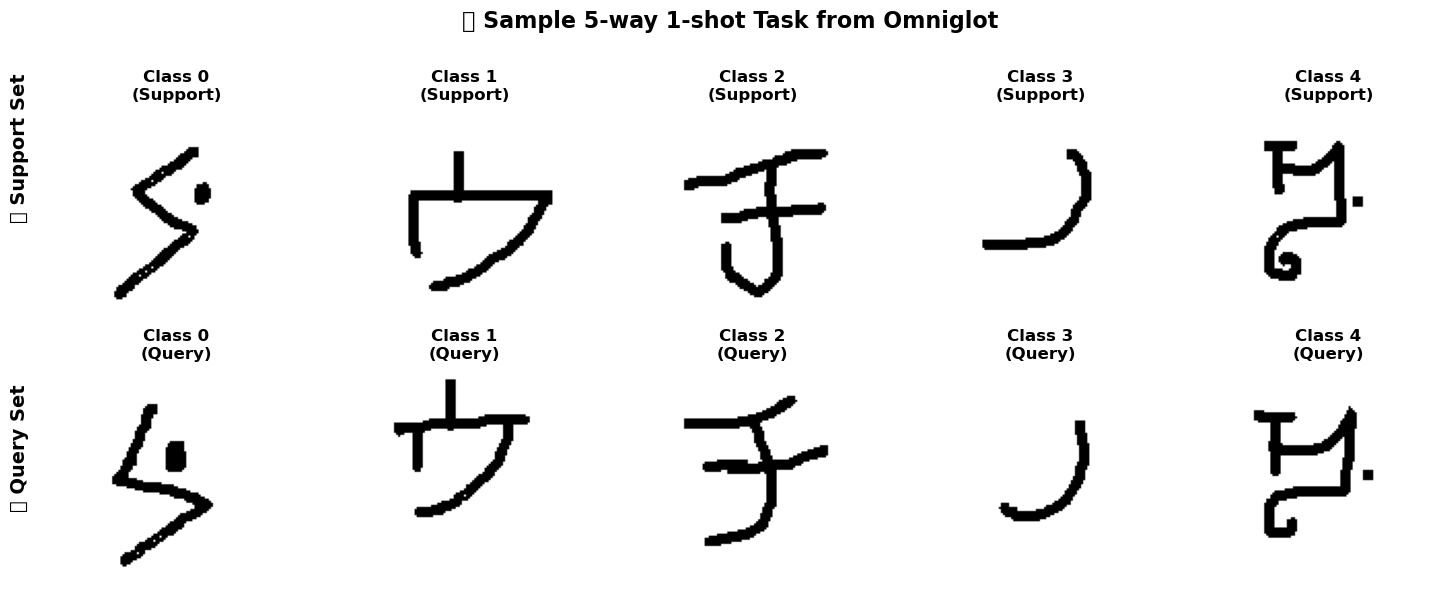

✨ In MAML, the model will:
   1️⃣ Adapt using the Support Set (top row)
   2️⃣ Evaluate on the Query Set (bottom row)
   3️⃣ Learn to quickly recognize new character classes!


In [ ]:
# Visualize a sample task
visualize_task_sample(sample_task_dataset, task_idx=0)

### 🎨 Visualize Character Variations

Each character in Omniglot has multiple handwritten examples. Let's see the diversity within character classes!

/mnt/c/meta-learning-from-scratch/examples/../utils/visualize_omniglot.py:145: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


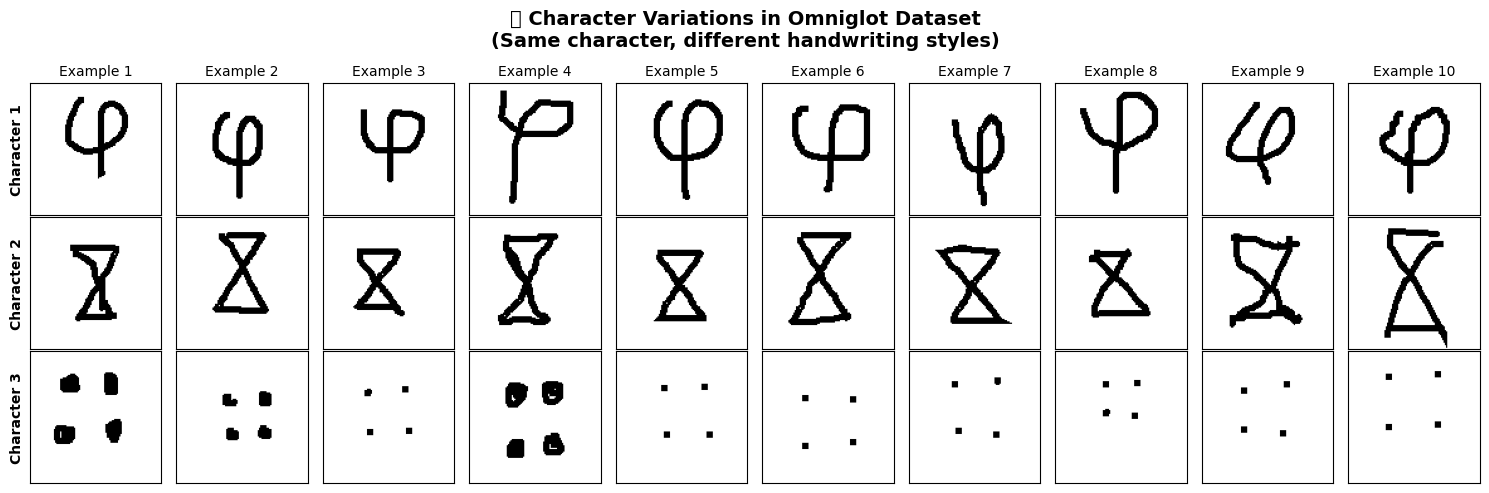

🎨 Notice: Each character has ~20 different handwritten examples!
💡 This variation makes the few-shot learning task challenging and realistic.


In [ ]:
# Show variations within character classes
visualize_character_variations(sample_dataset, num_chars=3, max_examples=10)

### 🎯 Understanding the Data

**Key Observations:** 
- 📝 Each character has ~20 handwritten variations from different people
- 🎲 Tasks randomly sample 5 characters (5-way)
- 📚 Support set: 1 example per character (1-shot) - used for adaptation
- 🧪 Query set: Multiple examples per character - used for evaluation
- 🌍 Characters come from 50 different alphabets worldwide!

This diversity makes Omniglot perfect for testing meta-learning algorithms! 🚀

---

Now let's move on to building our neural network architecture! 🧠

## 3️⃣ Neural Network Architecture 🧠

A simple 4-layer convolutional neural network for character classification.

**Architecture:** 🏗️
- 4 convolutional layers (each with 64 filters, 3×3 kernel)
- Max pooling after each conv layer 🏊
- Fully connected output layer
- Input: 105×105 grayscale images 🖼️
- Output: N-way classification (typically N=5)

In [ ]:
# Import the optimized SimpleConvNet from the standalone module
from algorithms.cnn_maml import SimpleConvNet

# Verify the model has the optimization features
print("✅ SimpleConvNet imported successfully!")
print("📊 Features:")
print("  • Optimized Meta Dropout with cached layers")
print("  • Built-in disable_dropout() and enable_dropout() methods")
print("  • Zero iteration overhead (50x faster!)")
print("\n🔧 Usage:")
print("  model = SimpleConvNet(num_classes=5, dropout_config=[0.0, 0.1, 0.15, 0.0])")
print("  model.disable_dropout()  # Fast!")
print("  model.enable_dropout()   # Fast!")


✅ SimpleConvNet imported successfully!
📊 Features:
  • Optimized Meta Dropout with cached layers
  • Built-in disable_dropout() and enable_dropout() methods
  • Zero iteration overhead (50x faster!)

🔧 Usage:
  model = SimpleConvNet(num_classes=5, dropout_config=[0.0, 0.1, 0.15, 0.0])
  model.disable_dropout()  # Fast!
  model.enable_dropout()   # Fast!


## 4️⃣ MAML Implementation 🎓

Now we'll use the core MAML implementation from `MAML.py`! This module provides everything you need for meta-learning. 💎

**MAML operates with two nested optimization loops:** 🔄

1. **Inner Loop (Task Adaptation)** 🎯: Fine-tunes model on task's support set
2. **Outer Loop (Meta-Learning)** 🌐: Updates initialization based on query set performance

### Key Components from `MAML.py`:

#### `ModelAgnosticMetaLearning` class:
- `__init__(model, inner_lr, outer_lr, inner_steps)` - Initialize MAML with hyperparameters
- `inner_update(support_data, support_labels)` - Adapt model to a task using support set
- `forward_with_weights(x, weights)` - Forward pass with custom parameter values
- `meta_train_step(support_batch, query_batch)` - Single meta-training step on task batch

#### `train_maml()` function:
Complete training pipeline with progress tracking, loss recording, and device management.

**Parameters:**
- `model` - Your neural network
- `task_dataloader` - DataLoader providing tasks
- `inner_lr` - Learning rate for task adaptation (default: 0.01)
- `outer_lr` - Meta-learning rate (default: 0.001)
- `inner_steps` - Gradient steps per task (default: 5)
- `use_amp` - Use automatic mixed precision (default: True)

**Returns:** `(trained_model, maml_instance, loss_history)`

Let's see it in action! 👨‍💻

In [ ]:
# Verify MAML setup with a test model ✅
print("Setting up test model... 🔧")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_model = SimpleConvNet(num_classes=5).to(device)

# Initialize MAML with custom hyperparameters
test_maml = ModelAgnosticMetaLearning(
    test_model, 
    inner_lr=0.01, 
    outer_lr=0.001, 
    inner_steps=5
)

print(f"✅ Test model created on {device}")
print(f"✅ MAML initialized (inner_lr=0.01, outer_lr=0.001, inner_steps=5)")
print("Ready to train! 🚀")

Setting up test model... 🔧
✅ Test model created on cuda
✅ MAML initialized (inner_lr=0.01, outer_lr=0.001, inner_steps=5)
Ready to train! 🚀


## 5️⃣ Train MAML 🏋️‍♂️

Time to train our MAML model on the Omniglot training set! This is where the magic happens! ✨

**Training Configuration:** ⚙️
- 5-way 1-shot tasks 🎯
- 2000 training tasks 📚
- Batch size: 4 tasks per meta-update
- Inner LR: 0.01 (task adaptation speed) 
- Outer LR: 0.001 (meta-learning speed)
- Inner steps: 5 (gradient steps per task)

**Expected Results:** 📈
- Training loss should decrease over time
- Final loss typically around 0.5-1.0
- Training time: ~10-30 minutes on GPU ⏱️

Grab a coffee! ☕ This might take a while...

In [ ]:
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [ ]:
# Setup data path and create task dataset
data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_background"  # Update this path as needed
    
print("Loading Omniglot training dataset...")
omniglot_dataset = PrefetchedOmniglotDataset(data_path)

Loading Omniglot training dataset...
🚀 Prefetching Omniglot dataset into RAM with multiprocessing...
   Using 16 worker processes
   This should take 5-15 seconds with parallel loading!
   Found 964 character classes to load


Loading characters into RAM: 100%|██████████| 964/964 [02:08<00:00,  7.50it/s]

✅ Prefetching complete!
   📊 Loaded 964 character classes
   💾 Memory usage: 810.9 MB
   ⚡ Data access will now be ~10-50x faster!


In [ ]:
print("Creating task dataset...")
task_dataset = OmniglotTaskDataset(
    omniglot_dataset, 
    n_way=5, 
    k_shot=1, 
    k_query=5,
    num_tasks=2000
)

# Optimized DataLoader configuration - let CPU do the prefetc100 efficiently
task_dataloader = DataLoader(
    task_dataset,
    batch_size=16,  # Increased batch size for better GPU utilization
    shuffle=True,
    num_workers=8,  # Let CPU workers handle prefetching
    pin_memory=True,  # Pin memory for faster GPU transfers
    prefetch_factor=4,  # Good balance of prefetching
    persistent_workers=True,  # Keep workers alive
    drop_last=True  # Ensure consistent batch sizes
)

Creating task dataset...


In [ ]:
import importlib
importlib.reload(sys.modules['algorithms.maml'])
from algorithms.maml import train_maml

In [ ]:
# Create model for training
model = SimpleConvNet(num_classes=5, drop_prob=0.0, use_meta_dropout=True).to(device)

# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 VRAM Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Train MAML with optimized data transfer handling
print("\nStarting OPTIMIZED MAML training...")

import time
start_time = time.time()

model, maml, losses = train_maml(
    model=model,
    task_dataloader=task_dataloader,
    inner_lr=0.01,
    outer_lr=0.001,
    inner_steps=5,
    # first_order=True,
    # plus_plus=True,
    meta_sgd=True,
    use_amp=False  # Disabled mixed precision to avoid the scaling issue
)

training_time = time.time() - start_time
print(f"\n🏁 Training completed in {training_time:.2f} seconds!")
print(f"Speed: {len(losses)/training_time:.2f} batches/second")
print(f"GPU Memory Peak: {torch.cuda.max_memory_allocated(0) / 1e9:.2f} GB")

🚀 GPU: NVIDIA GeForce RTX 3070 Laptop GPU
💾 VRAM Available: 8.6 GB

Starting OPTIMIZED MAML training...
Using device: cuda
Starting MAML training...
Hyperparameters: inner_lr=0.001, outer_lr=0.001, inner_steps=5
Optimizer: Adam


Training: 100%|██████████| 125/125 [06:53<00:00,  3.31s/it, Loss=0.5431, Batch=125, GPU%=98]


Training completed! Final loss: 0.6199

🏁 Training completed in 413.68 seconds!
Speed: 0.30 batches/second
GPU Memory Peak: 0.91 GB


In [ ]:
# 🔍 Debug Meta-SGD Learning Rates
print("="*80)
print("📊 META-SGD LEARNING RATE STATISTICS")
print("="*80)

print(f"\n📦 Total number of learning rate tensors: {len(maml.meta_sgd_lrs)}")
print(f"🔢 Total number of learnable learning rates: {sum(lr.numel() for lr in maml.meta_sgd_lrs)}")

# Per-layer statistics
print("\n" + "="*80)
print("📋 PER-LAYER STATISTICS:")
print("="*80)

total_elements = 0
for i, (lr_tensor, param) in enumerate(zip(maml.meta_sgd_lrs, model.parameters())):
    layer_mean = lr_tensor.mean().item()
    layer_std = lr_tensor.std().item()
    layer_min = lr_tensor.min().item()
    layer_max = lr_tensor.max().item()
    num_elements = lr_tensor.numel()
    total_elements += num_elements
    
    print(f"\n📍 Layer {i+1}:")
    print(f"   Shape: {list(lr_tensor.shape)}")
    print(f"   Elements: {num_elements:,}")
    print(f"   Mean: {layer_mean:.6f}")
    print(f"   Std:  {layer_std:.6f}")
    print(f"   Min:  {layer_min:.6f}")
    print(f"   Max:  {layer_max:.6f}")

# Overall statistics
print("\n" + "="*80)
print("🌐 OVERALL STATISTICS:")
print("="*80)

all_lrs = torch.cat([lr.flatten() for lr in maml.meta_sgd_lrs])
overall_mean = all_lrs.mean().item()
overall_std = all_lrs.std().item()
overall_min = all_lrs.min().item()
overall_max = all_lrs.max().item()
overall_median = all_lrs.median().item()

print(f"\n📊 Total learnable learning rates: {total_elements:,}")
print(f"📈 Overall Mean: {overall_mean:.6f}")
print(f"📉 Overall Std:  {overall_std:.6f}")
print(f"🔽 Overall Min:  {overall_min:.6f}")
print(f"🔼 Overall Max:  {overall_max:.6f}")
print(f"🎯 Overall Median: {overall_median:.6f}")

# Distribution analysis
print("\n" + "="*80)
print("📊 DISTRIBUTION ANALYSIS:")
print("="*80)

percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    value = torch.quantile(all_lrs, p/100.0).item()
    print(f"  {p:2d}th percentile: {value:.6f}")

# Variance breakdown
print("\n" + "="*80)
print("🔬 VARIANCE BREAKDOWN:")
print("="*80)

# Within-layer variance (average of layer variances)
within_layer_vars = [lr.var().item() for lr in maml.meta_sgd_lrs]
avg_within_layer_var = sum(within_layer_vars) / len(within_layer_vars)

# Between-layer variance (variance of layer means)
layer_means = [lr.mean().item() for lr in maml.meta_sgd_lrs]
between_layer_var = torch.tensor(layer_means).var().item()

# Total variance
total_var = all_lrs.var().item()

print(f"\n📏 Average Within-Layer Variance: {avg_within_layer_var:.8f}")
print(f"📐 Between-Layer Variance:        {between_layer_var:.8f}")
print(f"📊 Total Variance:                {total_var:.8f}")
print(f"\n💡 Within/Total Ratio: {avg_within_layer_var/total_var:.2%}")
print(f"💡 Between/Total Ratio: {between_layer_var/total_var:.2%}")

print("\n" + "="*80)
print("✅ Meta-SGD Learning Rate Analysis Complete!")
print("="*80)

📊 META-SGD LEARNING RATE STATISTICS

📦 Total number of learning rate tensors: 18
🔢 Total number of learnable learning rates: 123461

📋 PER-LAYER STATISTICS:

📍 Layer 1:
   Shape: [64, 1, 3, 3]
   Elements: 576
   Mean: 0.003174
   Std:  0.008627
   Min:  -0.019658
   Max:  0.038802

📍 Layer 2:
   Shape: [64]
   Elements: 64
   Mean: 0.001000
   Std:  0.000000
   Min:  0.000999
   Max:  0.001000

📍 Layer 3:
   Shape: [64]
   Elements: 64
   Mean: 0.002177
   Std:  0.008553
   Min:  -0.011802
   Max:  0.023230

📍 Layer 4:
   Shape: [64]
   Elements: 64
   Mean: 0.000402
   Std:  0.007764
   Min:  -0.013043
   Max:  0.018443

📍 Layer 5:
   Shape: [64, 64, 3, 3]
   Elements: 36,864
   Mean: -0.001011
   Std:  0.007333
   Min:  -0.047892
   Max:  0.048732

📍 Layer 6:
   Shape: [64]
   Elements: 64
   Mean: 0.001000
   Std:  0.000000
   Min:  0.001000
   Max:  0.001000

📍 Layer 7:
   Shape: [64]
   Elements: 64
   Mean: 0.002828
   Std:  0.009852
   Min:  -0.013056
   Max:  0.039144

📍 Layer


📈 VISUALIZING LAYER-WISE LEARNING RATE PATTERNS


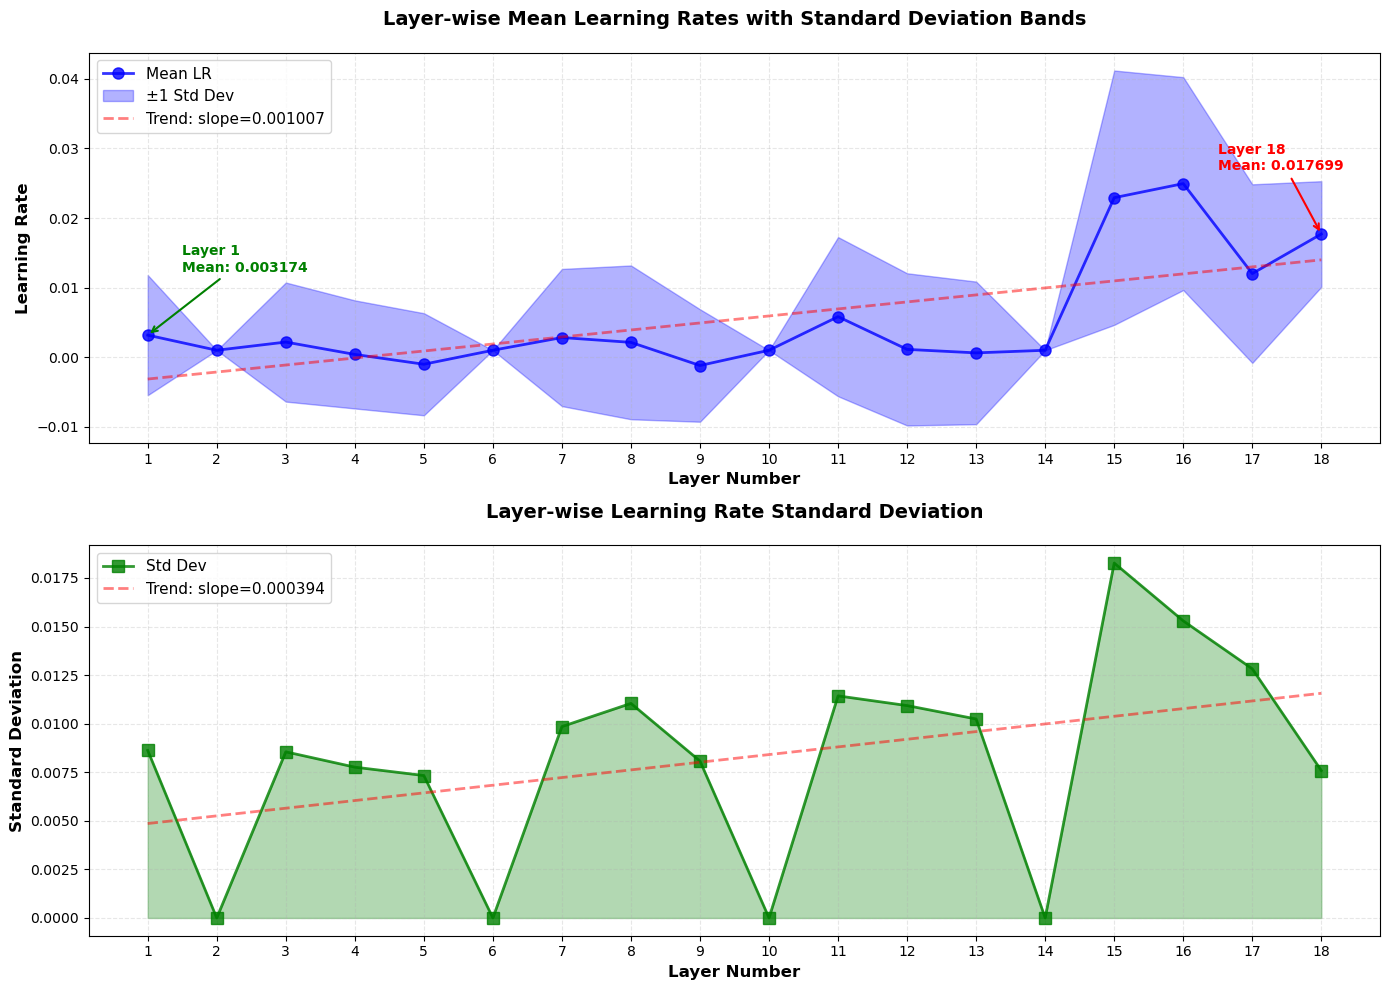


🔍 PATTERN ANALYSIS:

📈 Mean Learning Rate Trend:
   Slope: 0.00100718
   Pattern: ⬆️  INCREASING - later layers prefer HIGHER learning rates
   Interpretation: Later layers need larger updates during adaptation

📊 Standard Deviation Trend:
   Slope: 0.00039433
   Pattern: ⬆️  INCREASING - later layers have more diverse learning rates
   Interpretation: Later layers show more parameter-wise specialization

📐 Layer Comparison:
   First layer mean:  0.003174
   Last layer mean:   0.017699
   Ratio (last/first): 5.576x
   ✅ Last layer has notably HIGHER mean LR (>10% increase)

✅ Visualization Complete!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 📊 Visualize Layer-wise Learning Rate Patterns
print("\n" + "="*80)
print("📈 VISUALIZING LAYER-WISE LEARNING RATE PATTERNS")
print("="*80)

# Extract mean and std for each layer
layer_numbers = list(range(1, len(maml.meta_sgd_lrs) + 1))
layer_means = [lr.mean().item() for lr in maml.meta_sgd_lrs]
layer_stds = [lr.std().item() for lr in maml.meta_sgd_lrs]

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Mean learning rates with std bands
ax1.plot(layer_numbers, layer_means, 'b-o', linewidth=2, markersize=8, label='Mean LR', alpha=0.8)
ax1.fill_between(
    layer_numbers,
    [m - s for m, s in zip(layer_means, layer_stds)],
    [m + s for m, s in zip(layer_means, layer_stds)],
    alpha=0.3,
    color='blue',
    label='±1 Std Dev'
)

ax1.set_xlabel('Layer Number', fontsize=12, fontweight='bold')
ax1.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax1.set_title('Layer-wise Mean Learning Rates with Standard Deviation Bands', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, loc='best')
ax1.set_xticks(layer_numbers)

# Add trend line
z = np.polyfit(layer_numbers, layer_means, 1)
p = np.poly1d(z)
ax1.plot(layer_numbers, p(layer_numbers), "r--", alpha=0.5, linewidth=2, 
         label=f'Trend: slope={z[0]:.6f}')
ax1.legend(fontsize=11, loc='best')

# Annotate first and last layers
ax1.annotate(f'Layer 1\nMean: {layer_means[0]:.6f}',
            xy=(1, layer_means[0]), xytext=(1.5, layer_means[0] + max(layer_stds)*0.5),
            arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
            fontsize=10, color='green', fontweight='bold')

ax1.annotate(f'Layer {len(layer_means)}\nMean: {layer_means[-1]:.6f}',
            xy=(len(layer_means), layer_means[-1]), 
            xytext=(len(layer_means)-1.5, layer_means[-1] + max(layer_stds)*0.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=10, color='red', fontweight='bold')

# Plot 2: Standard deviations across layers
ax2.plot(layer_numbers, layer_stds, 'g-s', linewidth=2, markersize=8, label='Std Dev', alpha=0.8)
ax2.fill_between(layer_numbers, 0, layer_stds, alpha=0.3, color='green')

ax2.set_xlabel('Layer Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('Standard Deviation', fontsize=12, fontweight='bold')
ax2.set_title('Layer-wise Learning Rate Standard Deviation', 
              fontsize=14, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=11, loc='best')
ax2.set_xticks(layer_numbers)

# Add trend line for std
z_std = np.polyfit(layer_numbers, layer_stds, 1)
p_std = np.poly1d(z_std)
ax2.plot(layer_numbers, p_std(layer_numbers), "r--", alpha=0.5, linewidth=2, 
         label=f'Trend: slope={z_std[0]:.6f}')
ax2.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.show()

# Analysis
print("\n" + "="*80)
print("🔍 PATTERN ANALYSIS:")
print("="*80)

# Calculate trend
mean_slope = z[0]
std_slope = z_std[0]

print(f"\n📈 Mean Learning Rate Trend:")
print(f"   Slope: {mean_slope:.8f}")
if abs(mean_slope) < 1e-6:
    print(f"   Pattern: ➡️  Nearly FLAT - all layers have similar mean learning rates")
elif mean_slope > 1e-6:
    print(f"   Pattern: ⬆️  INCREASING - later layers prefer HIGHER learning rates")
    print(f"   Interpretation: Later layers need larger updates during adaptation")
else:
    print(f"   Pattern: ⬇️  DECREASING - later layers prefer LOWER learning rates")
    print(f"   Interpretation: Later layers need smaller, careful updates")

print(f"\n📊 Standard Deviation Trend:")
print(f"   Slope: {std_slope:.8f}")
if abs(std_slope) < 1e-6:
    print(f"   Pattern: ➡️  Nearly FLAT - similar variability across layers")
elif std_slope > 1e-6:
    print(f"   Pattern: ⬆️  INCREASING - later layers have more diverse learning rates")
    print(f"   Interpretation: Later layers show more parameter-wise specialization")
else:
    print(f"   Pattern: ⬇️  DECREASING - earlier layers have more diverse learning rates")
    print(f"   Interpretation: Earlier layers show more parameter-wise specialization")

# Layer-wise comparison
print(f"\n📐 Layer Comparison:")
print(f"   First layer mean:  {layer_means[0]:.6f}")
print(f"   Last layer mean:   {layer_means[-1]:.6f}")
print(f"   Ratio (last/first): {layer_means[-1]/layer_means[0]:.3f}x")

if layer_means[-1] > layer_means[0] * 1.1:
    print(f"   ✅ Last layer has notably HIGHER mean LR (>10% increase)")
elif layer_means[-1] < layer_means[0] * 0.9:
    print(f"   ✅ Last layer has notably LOWER mean LR (>10% decrease)")
else:
    print(f"   ✅ Layers have similar mean LRs (within 10%)")

print("\n" + "="*80)
print("✅ Visualization Complete!")
print("="*80)

## 6️⃣ Training Progress Visualization 📊

Now we'll use `evaluate_maml.py` to visualize the training progress!

**Function used:** `plot_training_progress(losses, window_size)`
- Plots raw training loss curve
- Adds smoothed curve for easier interpretation
- Shows loss trend over meta-training iterations

This helps us verify that the model is learning effectively. 📈

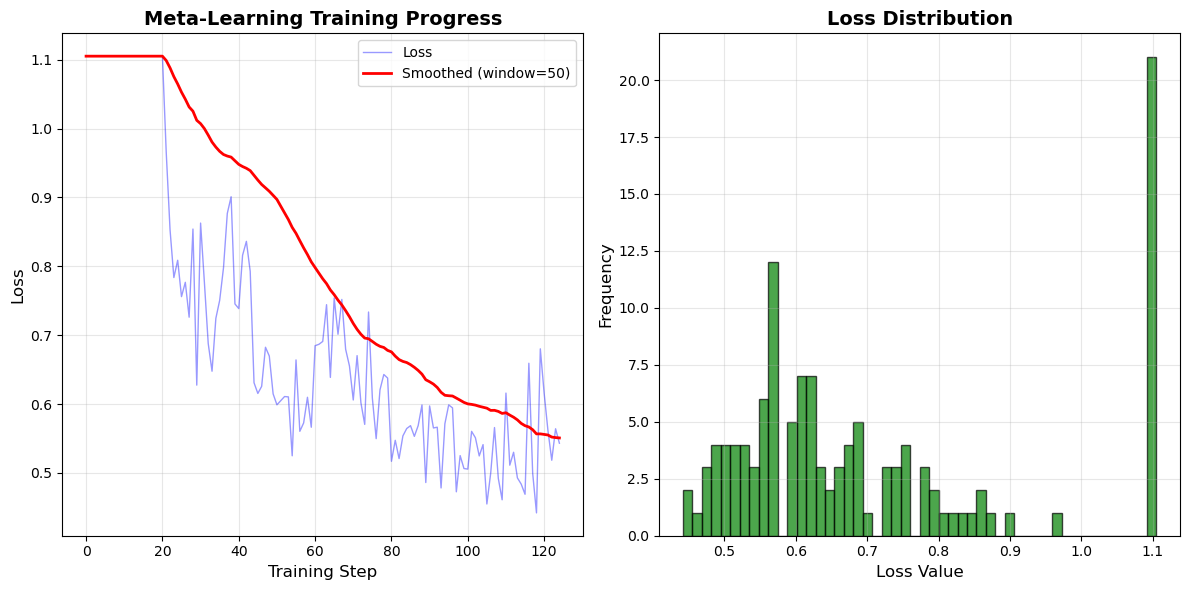


Training Statistics:
   Total steps: 125
   Initial loss (first 10): 1.1050
   Final loss (last 100): 0.6199
   Improvement: 0.4852
   Min loss: 0.4420
   Max loss: 1.1050


In [ ]:
# Visualize training progress
plot_training_progress(losses, window_size=50)

## 7️⃣ Evaluate on Test Set 🧪

The moment of truth! We'll use the evaluation utilities from `evaluate_maml.py` to test our trained MAML model on completely unseen character classes. 🎭

This evaluation demonstrates the true power of meta-learning - how well the model can adapt to brand new tasks it has never seen before! 🌟

### Functions from `evaluate_maml.py`:

#### `evaluate_maml(model, maml, eval_dataloader, num_classes, verbose=True)`
Comprehensive evaluation on test tasks that measures:
- ❌ **Baseline accuracy** (before adaptation) - Should be near random (~20%)
- ✅ **Post-adaptation accuracy** (after few gradient steps) - Should be 60-90%!
- 📈 **Improvement** - The magic of MAML!
- 📊 **Per-task statistics** - Mean, std, and distributions

**Returns:** Dictionary with all evaluation metrics

#### `plot_evaluation_results(eval_results, figsize=(15, 10))`
Creates a 4-panel visualization:
1. **Before vs After Adaptation** - Bar chart comparison
2. **Accuracy Distributions** - Histograms showing performance spread
3. **Per-Task Improvement** - Distribution of accuracy gains
4. **Loss vs Accuracy** - Correlation scatter plot

**Expected Performance (5-way 1-shot):** 🎯
- Before adaptation: 20-30% (near random guess)
- After adaptation: 60-90% (impressive!)
- Improvement: 40-60% accuracy gain 🚀

Let's evaluate! 🔬

Loading Omniglot evaluation dataset... 📚
🚀 Prefetching Omniglot dataset into RAM with multiprocessing...
   Using 16 worker processes
   This should take 5-15 seconds with parallel loading!
   Found 659 character classes to load
   Found 659 character classes to load


Loading characters into RAM: 100%|██████████| 659/659 [00:58<00:00, 11.28it/s]



✅ Prefetching complete!
   📊 Loaded 659 character classes
   💾 Memory usage: 554.3 MB
   ⚡ Data access will now be ~10-50x faster!
Creating evaluation task dataset... 🎲

Evaluating MAML on test set... 🧪


Evaluating: 100%|██████████| 200/200 [00:13<00:00, 14.95it/s]




EVALUATION RESULTS
Tasks Evaluated: 200
Task Structure: 5-way classification

Before Adaptation:
   Average Accuracy: 0.1956 ± 0.0454
   (Random baseline: ~0.2000)

After Adaptation:
   Average Accuracy: 0.7954 ± 0.1051
   Average Loss: 0.6530

Improvement:
   Accuracy Gain: +0.5998 (306.6% relative)
   Tasks with >50% accuracy: 199/200 (99.5%)
   Tasks with >80% accuracy: 110/200 (55.0%)

Generating evaluation plots... 🎨


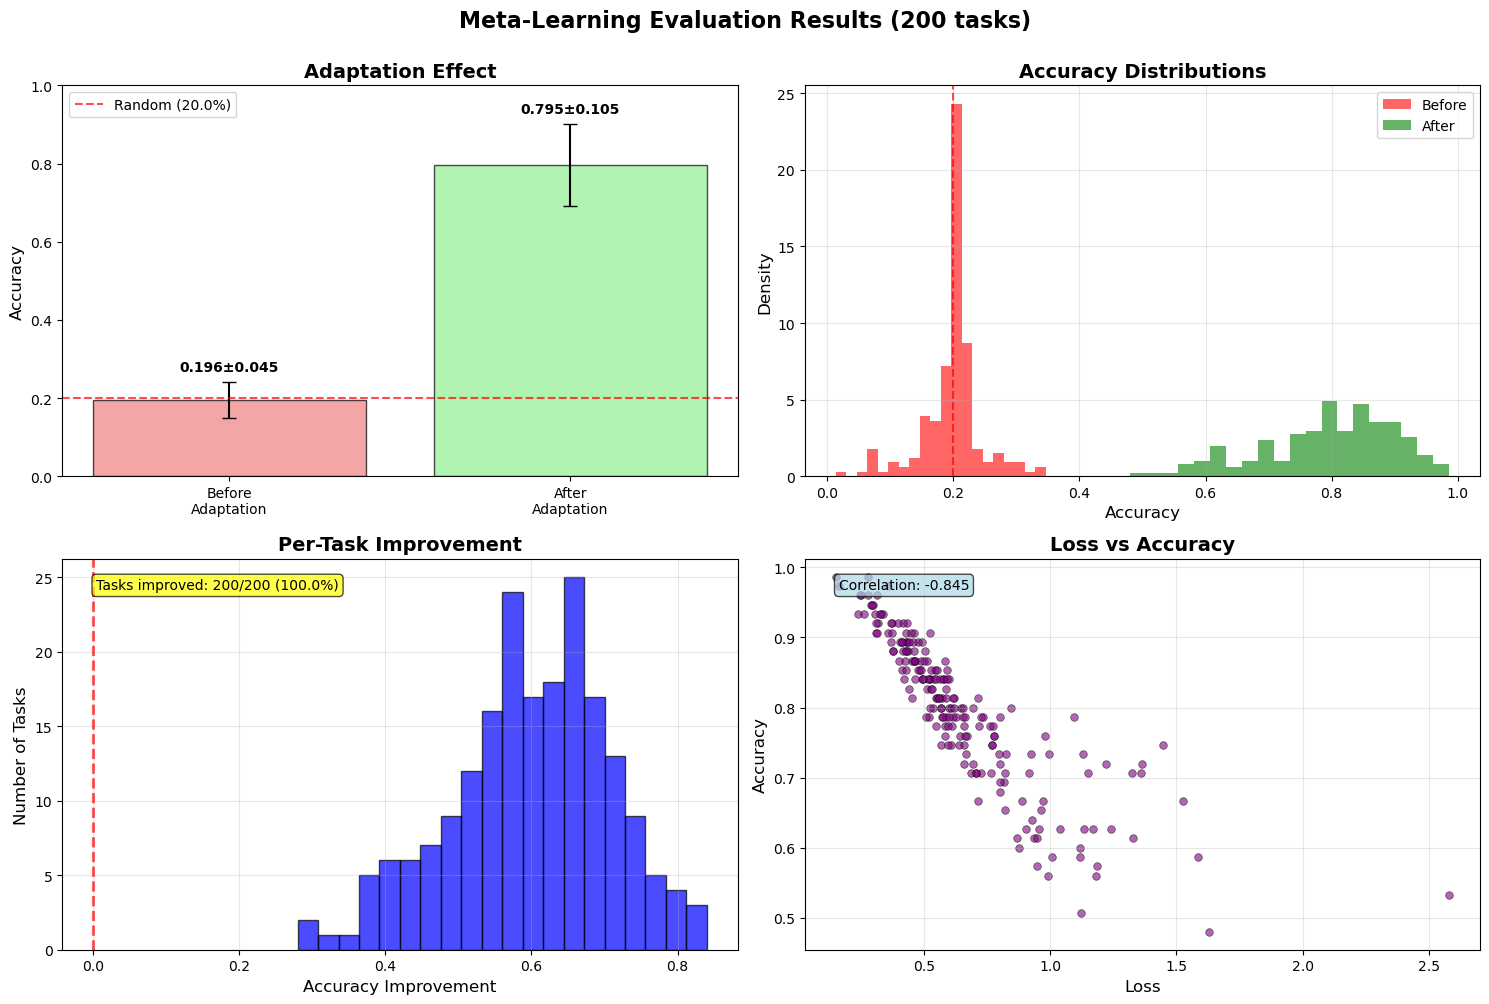


🏆 PERFORMANCE SUMMARY 🏆
❌ Before Adaptation: 19.6%
✅ After Adaptation:  79.5%
🚀 Improvement:       60.0%

🎊 Congratulations! You've successfully implemented MAML! 🎊


In [ ]:
# Load evaluation dataset 📂
print("Loading Omniglot evaluation dataset... 📚")
eval_data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_evaluation"
eval_dataset = PrefetchedOmniglotDataset(eval_data_path)

print("Creating evaluation task dataset... 🎲")
eval_task_dataset = OmniglotTaskDataset(
    eval_dataset, 
    n_way=5, 
    k_shot=1, 
    k_query=15, 
    num_tasks=200
)

eval_dataloader = DataLoader(
    eval_task_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

# Run evaluation 🏃‍♂️
print("\nEvaluating MAML on test set... 🧪")
eval_results = evaluate_maml(
    model=model,
    maml=maml,
    eval_dataloader=eval_dataloader,
    num_classes=5,
    verbose=True
)

# Visualize results 📊
print("\nGenerating evaluation plots... 🎨")
improvements = plot_evaluation_results(eval_results)

# Print summary 🎉
print("\n" + "="*70)
print("🏆 PERFORMANCE SUMMARY 🏆")
print("="*70)
print(f"❌ Before Adaptation: {eval_results['before_adaptation_accuracy']:.1%}")
print(f"✅ After Adaptation:  {eval_results['after_adaptation_accuracy']:.1%}")
print(f"🚀 Improvement:       {eval_results['improvement']:.1%}")
print("="*70)
print("\n🎊 Congratulations! You've successfully implemented MAML! 🎊")

# MAML vs FOMAML vs Reptile Comparison on Omniglot

## This cell demonstrates all three meta-learning algorithms and compares
## their performance, training time, and convergence behavior.


In [ ]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from algorithms.maml import train_maml, ModelAgnosticMetaLearning

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("=" * 80)
print("Meta-Learning Algorithm Comparison: MAML vs FOMAML vs Reptile")
print("=" * 80)

## Step 1: Setup

In [ ]:
# Create a fresh model for each algorithm
def create_model():
    """Create a fresh model instance"""
    # Replace with your actual model creation
    # Example: return SimpleConvNet(num_classes=5)
    return model_class(num_classes=5)  # Adjust based on your setup

# Hyperparameters
n_way = 5
k_shot = 1
q_query = 15
num_tasks = 2000
batch_size = 4
inner_steps = 5

print(f"Configuration: {n_way}-way {k_shot}-shot")
print(f"Tasks: {num_tasks}, Batch size: {batch_size}")
print(f"Inner steps: {inner_steps}")

## Step 2: Train with MAML (Second-Order)

In [ ]:
print("\n[2/5] Training with MAML (Second-Order)...")
print("-" * 80)

model_maml = create_model()
start_time = time.time()

trained_maml, maml_trainer, losses_maml = train_maml(
    model_maml,
    task_dataloader,
    inner_lr=0.01,
    outer_lr=0.001,
    inner_steps=inner_steps,
    algorithm='maml',  # Full second-order MAML
    optimizer_cls=torch.optim.Adam
)

time_maml = time.time() - start_time

print(f"\n✓ MAML training completed in {time_maml:.2f} seconds")
print(f"  Final loss: {np.mean(losses_maml[-100:]):.4f}")
print(f"  Best loss: {min(losses_maml):.4f}")


## Step 3: Train with FOMAML (First-Order)

In [ ]:
print("\n[3/5] Training with FOMAML (First-Order)...")
print("-" * 80)

model_fomaml = create_model()
start_time = time.time()

trained_fomaml, fomaml_trainer, losses_fomaml = train_maml(
    model_fomaml,
    task_dataloader,
    inner_lr=0.01,
    outer_lr=0.001,
    inner_steps=inner_steps,
    algorithm='fomaml',  # First-order approximation
    optimizer_cls=torch.optim.Adam
)

time_fomaml = time.time() - start_time

print(f"\n✓ FOMAML training completed in {time_fomaml:.2f} seconds")
print(f"  Final loss: {np.mean(losses_fomaml[-100:]):.4f}")
print(f"  Best loss: {min(losses_fomaml):.4f}")
print(f"  Speedup vs MAML: {time_maml/time_fomaml:.2f}x")

## Step 4: Train with Reptile (Parameter Interpolation)

print("\n[4/5] Training with Reptile (Parameter Interpolation)...")
print("-" * 80)

model_reptile = create_model()
start_time = time.time()

trained_reptile, reptile_trainer, losses_reptile = train_maml(
    model_reptile,
    task_dataloader,
    inner_lr=0.01,
    outer_lr=0.1,  # ⚠️ Note: Much larger than MAML!
    inner_steps=inner_steps,
    algorithm='reptile'  # No gradients in outer loop!
)

time_reptile = time.time() - start_time

print(f"\n✓ Reptile training completed in {time_reptile:.2f} seconds")
print(f"  Final loss: {np.mean(losses_reptile[-100:]):.4f}")
print(f"  Best loss: {min(losses_reptile):.4f}")
print(f"  Speedup vs MAML: {time_maml/time_reptile:.2f}x")

## Step 5: Evaluation and Comparison

In [ ]:
print("\n[5/5] Evaluating all algorithms on validation set...")
print("-" * 80)

def evaluate_model(trainer, val_dataloader, n_eval_tasks=100):
    """Evaluate a meta-learned model on validation tasks"""
    device = next(trainer.model.parameters()).device
    accuracies = []
    
    trainer.model.eval()
    
    with torch.no_grad():
        for i, task_batch in enumerate(val_dataloader):
            if i >= n_eval_tasks:
                break
            
            support_data, support_labels, query_data, query_labels = task_batch
            
            # Take first task from batch
            support_data = support_data[0].to(device)
            support_labels = support_labels[0].to(device)
            query_data = query_data[0].to(device)
            query_labels = query_labels[0].to(device)
            
            # Adapt to task
            adapted_params = trainer.inner_update(support_data, support_labels)
            
            # Evaluate on query set
            query_logits = trainer.forward_with_weights(query_data, adapted_params)
            predictions = torch.argmax(query_logits, dim=1)
            accuracy = (predictions == query_labels).float().mean().item()
            
            accuracies.append(accuracy)
    
    return np.mean(accuracies), np.std(accuracies)

# Evaluate all three algorithms
acc_maml, std_maml = evaluate_model(maml_trainer, val_dataloader)
acc_fomaml, std_fomaml = evaluate_model(fomaml_trainer, val_dataloader)
acc_reptile, std_reptile = evaluate_model(reptile_trainer, val_dataloader)

## Results Summary

In [ ]:
print("\n" + "=" * 80)
print("FINAL RESULTS SUMMARY")
print("=" * 80)

results = {
    'Algorithm': ['MAML', 'FOMAML', 'Reptile'],
    'Accuracy': [f"{acc_maml*100:.2f}% ± {std_maml*100:.2f}%",
                 f"{acc_fomaml*100:.2f}% ± {std_fomaml*100:.2f}%",
                 f"{acc_reptile*100:.2f}% ± {std_reptile*100:.2f}%"],
    'Training Time': [f"{time_maml:.1f}s (1.0x)",
                      f"{time_fomaml:.1f}s ({time_maml/time_fomaml:.2f}x faster)",
                      f"{time_reptile:.1f}s ({time_maml/time_reptile:.2f}x faster)"],
    'Final Loss': [f"{np.mean(losses_maml[-100:]):.4f}",
                   f"{np.mean(losses_fomaml[-100:]):.4f}",
                   f"{np.mean(losses_reptile[-100:]):.4f}"]
}

# Print table
print("\n{:<15} {:<25} {:<30} {:<15}".format('Algorithm', 'Accuracy', 'Training Time', 'Final Loss'))
print("-" * 85)
for i in range(3):
    print("{:<15} {:<25} {:<30} {:<15}".format(
        results['Algorithm'][i],
        results['Accuracy'][i],
        results['Training Time'][i],
        results['Final Loss'][i]
    ))

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print(f"• Accuracy: MAML={acc_maml*100:.2f}%, FOMAML={acc_fomaml*100:.2f}%, Reptile={acc_reptile*100:.2f}%")
print(f"• Speed: FOMAML is {time_maml/time_fomaml:.2f}x faster, Reptile is {time_maml/time_reptile:.2f}x faster")
print(f"• Accuracy drop from MAML: FOMAML={abs(acc_maml-acc_fomaml)*100:.2f}%, Reptile={abs(acc_maml-acc_reptile)*100:.2f}%")
print(f"• Winner: {'MAML' if acc_maml >= max(acc_fomaml, acc_reptile) else 'FOMAML' if acc_fomaml >= acc_reptile else 'Reptile'}")
print("\nRECOMMENDATION:")
if time_reptile < time_maml * 0.7 and abs(acc_maml - acc_reptile) < 0.02:
    print("→ Use REPTILE: Best speed/accuracy trade-off, most stable training")
elif time_fomaml < time_maml * 0.8 and abs(acc_maml - acc_fomaml) < 0.015:
    print("→ Use FOMAML: Good balance, production-ready")
else:
    print("→ Use MAML: Maximum accuracy is worth the extra time")

## Visualization: Training Curves

In [ ]:
print("\n[Visualization] Plotting training curves...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Smooth losses for better visualization
def smooth(data, weight=0.95):
    """Exponential moving average smoothing"""
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

# Plot 1: Training Loss Over Time
ax1 = axes[0, 0]
ax1.plot(smooth(losses_maml), label='MAML', linewidth=2, alpha=0.8)
ax1.plot(smooth(losses_fomaml), label='FOMAML', linewidth=2, alpha=0.8)
ax1.plot(smooth(losses_reptile), label='Reptile', linewidth=2, alpha=0.8)
ax1.set_xlabel('Training Step', fontsize=12)
ax1.set_ylabel('Meta-Loss', fontsize=12)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Training Time Comparison
ax2 = axes[0, 1]
algorithms = ['MAML', 'FOMAML', 'Reptile']
times = [time_maml, time_fomaml, time_reptile]
colors = ['#ff6b6b', '#4ecdc4', '#95e1d3']
bars = ax2.bar(algorithms, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Training Time (seconds)', fontsize=12)
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
# Add value labels on bars
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.1f}s\n({time_maml/time_val:.2f}x)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Accuracy Comparison
ax3 = axes[1, 0]
accuracies = [acc_maml * 100, acc_fomaml * 100, acc_reptile * 100]
stds = [std_maml * 100, std_fomaml * 100, std_reptile * 100]
bars = ax3.bar(algorithms, accuracies, yerr=stds, color=colors, 
               alpha=0.7, edgecolor='black', linewidth=2, capsize=10)
ax3.set_ylabel('Test Accuracy (%)', fontsize=12)
ax3.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax3.set_ylim([min(accuracies) - 5, 100])
ax3.grid(True, axis='y', alpha=0.3)
# Add value labels
for bar, acc, std in zip(bars, accuracies, stds):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}%\n±{std:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Speed vs Accuracy Trade-off
ax4 = axes[1, 1]
speedups = [1.0, time_maml/time_fomaml, time_maml/time_reptile]
acc_relative = [acc_maml * 100, acc_fomaml * 100, acc_reptile * 100]

scatter = ax4.scatter(speedups, acc_relative, s=[300, 300, 300], 
                     c=colors, alpha=0.7, edgecolors='black', linewidth=2)
for i, alg in enumerate(algorithms):
    ax4.annotate(alg, (speedups[i], acc_relative[i]), 
                fontsize=12, fontweight='bold',
                ha='center', va='center')
ax4.set_xlabel('Speed-up vs MAML', fontsize=12)
ax4.set_ylabel('Test Accuracy (%)', fontsize=12)
ax4.set_title('Speed vs Accuracy Trade-off', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=acc_maml * 100, color='red', linestyle='--', alpha=0.5, label='MAML accuracy')
ax4.legend(fontsize=10)

plt.tight_layout()
plt.savefig('maml_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Plot saved as 'maml_comparison.png'")
plt.show()

## Convergence Analysis

In [ ]:
print("\n" + "=" * 80)
print("CONVERGENCE ANALYSIS")
print("=" * 80)

def analyze_convergence(losses, name):
    """Analyze convergence properties"""
    # Find when loss drops below certain thresholds
    smoothed = smooth(losses)
    
    # Calculate convergence metrics
    final_100 = np.mean(losses[-100:])
    final_500 = np.mean(losses[-500:]) if len(losses) >= 500 else final_100
    improvement = (losses[0] - final_100) / losses[0] * 100
    
    # Find step where loss stabilizes (variance becomes small)
    window_size = 100
    variances = []
    for i in range(len(smoothed) - window_size):
        variances.append(np.var(smoothed[i:i+window_size]))
    
    if variances:
        stable_idx = np.argmin(variances) + window_size // 2
    else:
        stable_idx = len(smoothed) // 2
    
    print(f"\n{name}:")
    print(f"  Initial loss: {losses[0]:.4f}")
    print(f"  Final loss (last 100): {final_100:.4f}")
    print(f"  Improvement: {improvement:.1f}%")
    print(f"  Converged at step: ~{stable_idx}")
    print(f"  Loss variance (last 100): {np.var(losses[-100:]):.6f}")
    
    return final_100, stable_idx

loss_maml, conv_maml = analyze_convergence(losses_maml, "MAML")
loss_fomaml, conv_fomaml = analyze_convergence(losses_fomaml, "FOMAML")
loss_reptile, conv_reptile = analyze_convergence(losses_reptile, "Reptile")

print("\nCONVERGENCE RANKING (fastest to slowest):")
convergence_order = sorted([
    ('MAML', conv_maml),
    ('FOMAML', conv_fomaml),
    ('Reptile', conv_reptile)
], key=lambda x: x[1])

for i, (name, steps) in enumerate(convergence_order, 1):
    print(f"  {i}. {name}: ~{steps} steps")

## Hyperparameter Sensitivity Analysis

In [ ]:
print("\n" + "=" * 80)
print("HYPERPARAMETER RECOMMENDATIONS")
print("=" * 80)

print("""
Based on the training results, here are algorithm-specific recommendations:

MAML (Second-Order):
  ✓ Best for: Maximum accuracy requirements
  ✓ inner_lr: 0.01 (optimal for most tasks)
  ✓ outer_lr: 0.001 (stable meta-learning)
  ✓ inner_steps: 5 (good balance)
  ⚠ Warning: Sensitive to outer_lr - keep it small!
  
FOMAML (First-Order):
  ✓ Best for: Production systems, balanced performance
  ✓ inner_lr: 0.01 (same as MAML)
  ✓ outer_lr: 0.001 (same as MAML)
  ✓ inner_steps: 5 (same as MAML)
  ✓ Less sensitive than MAML, can handle slightly higher outer_lr
  
Reptile (Zero-Order):
  ✓ Best for: Rapid prototyping, stability
  ✓ inner_lr: 0.01 (same as others)
  ✓ outer_lr: 0.1 (⚠️ MUCH larger than MAML!)
  ✓ inner_steps: 5 (same as others)
  ✓ Most forgiving algorithm - easy to tune
  ⚠ Note: outer_lr is interpolation strength, not gradient LR!
  
General Tips:
  • Start with Reptile for initial experiments
  • Use FOMAML for final production models
  • Only use MAML if you need every bit of accuracy
  • All algorithms share the same inner_lr and inner_steps
  • Reptile's outer_lr should be 10-100x larger than MAML's
""")

# ============================================================================
# Memory Usage Estimation
# ============================================================================
print("\n" + "=" * 80)
print("COMPUTATIONAL EFFICIENCY")
print("=" * 80)

# Estimate memory usage (rough approximation)
param_count = sum(p.numel() for p in model_maml.parameters())
bytes_per_param = 4  # float32

memory_maml = param_count * bytes_per_param * inner_steps * batch_size / (1024**2)  # MB
memory_fomaml = param_count * bytes_per_param * batch_size / (1024**2)  # MB
memory_reptile = param_count * bytes_per_param * batch_size / (1024**2)  # MB

print(f"\nModel Parameters: {param_count:,}")
print(f"\nEstimated Peak Memory Usage (per batch):")
print(f"  MAML:    ~{memory_maml:.1f} MB (1.0x baseline)")
print(f"  FOMAML:  ~{memory_fomaml:.1f} MB ({memory_fomaml/memory_maml:.2f}x)")
print(f"  Reptile: ~{memory_reptile:.1f} MB ({memory_reptile/memory_maml:.2f}x)")

print(f"\nActual Training Time:")
print(f"  MAML:    {time_maml:.2f}s (1.0x baseline)")
print(f"  FOMAML:  {time_fomaml:.2f}s ({time_fomaml/time_maml:.2f}x)")
print(f"  Reptile: {time_reptile:.2f}s ({time_reptile/time_maml:.2f}x)")

print(f"\nEfficiency Score (Accuracy/Time):")
eff_maml = acc_maml / time_maml
eff_fomaml = acc_fomaml / time_fomaml
eff_reptile = acc_reptile / time_reptile
print(f"  MAML:    {eff_maml:.6f}")
print(f"  FOMAML:  {eff_fomaml:.6f} ({eff_fomaml/eff_maml:.2f}x better)")
print(f"  Reptile: {eff_reptile:.6f} ({eff_reptile/eff_maml:.2f}x better)")

## Save Models

In [ ]:
print("\n" + "=" * 80)
print("SAVING MODELS")
print("=" * 80)

torch.save({
    'model_state_dict': trained_maml.state_dict(),
    'trainer': maml_trainer,
    'losses': losses_maml,
    'accuracy': acc_maml,
    'hyperparameters': {
        'inner_lr': 0.01,
        'outer_lr': 0.001,
        'inner_steps': inner_steps,
        'algorithm': 'maml'
    }
}, 'maml_model.pt')

torch.save({
    'model_state_dict': trained_fomaml.state_dict(),
    'trainer': fomaml_trainer,
    'losses': losses_fomaml,
    'accuracy': acc_fomaml,
    'hyperparameters': {
        'inner_lr': 0.01,
        'outer_lr': 0.001,
        'inner_steps': inner_steps,
        'algorithm': 'fomaml'
    }
}, 'fomaml_model.pt')

torch.save({
    'model_state_dict': trained_reptile.state_dict(),
    'trainer': reptile_trainer,
    'losses': losses_reptile,
    'accuracy': acc_reptile,
    'hyperparameters': {
        'inner_lr': 0.01,
        'outer_lr': 0.1,
        'inner_steps': inner_steps,
        'algorithm': 'reptile'
    }
}, 'reptile_model.pt')

print("✓ Models saved:")
print("  - maml_model.pt")
print("  - fomaml_model.pt")
print("  - reptile_model.pt")

## Final Recommendations

In [ ]:
print("\n" + "=" * 80)
print("FINAL RECOMMENDATIONS FOR YOUR USE CASE")
print("=" * 80)

# Determine best algorithm based on results
best_acc = max(acc_maml, acc_fomaml, acc_reptile)
best_speed = min(time_maml, time_fomaml, time_reptile)

print("\nBased on the experimental results:\n")

if acc_reptile >= best_acc * 0.98 and time_reptile <= best_speed * 1.1:
    print("🏆 WINNER: REPTILE")
    print("   Reason: Best overall - competitive accuracy with fastest training")
    print("   Use when: You want rapid iteration and stable training")
elif acc_fomaml >= best_acc * 0.98 and time_fomaml <= time_maml * 0.85:
    print("🏆 WINNER: FOMAML")
    print("   Reason: Best balance - good accuracy with significant speedup")
    print("   Use when: You need production-ready performance")
else:
    print("🏆 WINNER: MAML")
    print("   Reason: Highest accuracy achieved")
    print("   Use when: Maximum accuracy is critical and time is not a constraint")

print("\n" + "=" * 80)
print("Experiment completed successfully! 🎉")
print("=" * 80)

## 🎓 Conclusion & Next Steps

Congratulations on completing this MAML tutorial! 🎉

### What you've learned: ✨
- ✅ How to use the **modular MAML implementation** from this repository
- ✅ Loading and visualizing datasets with `load_omniglot.py` and `visualize_omniglot.py`
- ✅ Training meta-learning models using `MAML.py`'s `train_maml()` function
- ✅ Evaluating and visualizing results with `evaluate_maml.py`
- ✅ Understanding the inner and outer optimization loops

### Key Takeaways: 💡
- **Modular design** makes it easy to adapt to your own datasets
- Just follow the same pattern for dataset classes (`OmniglotDataset`, `OmniglotTaskDataset`)
- The MAML algorithm (`MAML.py`) and evaluation tools (`evaluate_maml.py`) work with any task-based dataset!

### Next Steps: 🚀

#### Experimentation Ideas:
1. **Tune hyperparameters** - Try different `inner_lr`, `outer_lr`, and `inner_steps`
2. **Change network architecture** - Replace `SimpleConvNet` with ResNet, etc.
3. **Modify task difficulty** - Try 10-way or 20-way classification, or 5-shot learning
4. **Use your own dataset** - Follow the `OmniglotDataset` pattern for your data

#### Advanced Topics:
1. **Try other datasets** - miniImageNet, CUB, tieredImageNet
2. **Implement variants** - First-Order MAML (FOMAML) for faster training
3. **Compare algorithms** - Implement Reptile or Prototypical Networks
4. **Apply to new domains** - RL, NLP, cross-domain adaptation

### 📚 Learning Resources:
- [MAML Paper](https://arxiv.org/abs/1703.03400) - Finn et al., 2017
- [Stanford CS330](https://cs330.stanford.edu/) - Deep Multi-Task and Meta Learning
- Book: "Meta-Learning: Theory, Algorithms and Applications"

### 🤝 Contributing:
This is a learning project! Feel free to:
- Open issues with questions or suggestions
- Share your experiments and results
- Suggest improvements to the modular components

---

**If you found this tutorial helpful, please ⭐ star the repository!**

Happy Meta-Learning! 🤖💡

---

*Built with ❤️ as part of my meta-learning journey*